> In many applications, data may be spread across a number of files or databases or be arranged in a form that is not easy to analyze. This chapter focuses on tools to help combine, join, and rearrange data

# 8.1 Hierarchical Indexing

Hierarchical indexing is an important feature of pandas that enables you to **have multiple (two or more) index levels on an axis**

Somewhat abstractly, it **provides a way for you to work with higher dimensional data in a lower dimensional form**

Let’s start with a simple example; create a Series with a list of lists (or arrays) as the index:

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.Series(np.random.randn(9),
                 index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],
                        [1, 2, 3, 1, 3, 1, 2, 2, 3]])

In [3]:
data

a  1   -0.064114
   2   -1.304996
   3    1.202142
b  1    0.147964
   3   -0.190142
c  1    0.069983
   2    0.975693
d  2    0.064994
   3   -0.473923
dtype: float64

What you’re seeing is a prettified view of a Series with a MultiIndex as its index

The “gaps” in the index display mean “use the label directly above”:

In [4]:
data.index

MultiIndex([('a', 1),
            ('a', 2),
            ('a', 3),
            ('b', 1),
            ('b', 3),
            ('c', 1),
            ('c', 2),
            ('d', 2),
            ('d', 3)],
           )

With a hierarchically indexed object, so-called **partial indexing** is possible, enabling you to concisely select subsets of the data:

In [5]:
data['b']

1    0.147964
3   -0.190142
dtype: float64

In [6]:
data['b':'c']

b  1    0.147964
   3   -0.190142
c  1    0.069983
   2    0.975693
dtype: float64

In [7]:
data.loc[['b', 'd']]

b  1    0.147964
   3   -0.190142
d  2    0.064994
   3   -0.473923
dtype: float64

Selection is even possible from an “inner” level:

In [8]:
data.loc[:,2]

a   -1.304996
c    0.975693
d    0.064994
dtype: float64

Hierarchical indexing plays an important role in reshaping data and group-based operations like forming a pivot table

For example, **you could rearrange the data into a DataFrame using its unstack method:**

In [9]:
data.unstack()

,1,2,3
a,-0.064114,-1.304996,1.202142
b,0.147964,NaN,-0.190142
c,0.069983,0.975693,NaN
d,NaN,0.064994,-0.473923


For example, you could rearrange the data into a DataFrame using its unstack method:

In [10]:
data.unstack().stack()

a  1   -0.064114
   2   -1.304996
   3    1.202142
b  1    0.147964
   3   -0.190142
c  1    0.069983
   2    0.975693
d  2    0.064994
   3   -0.473923
dtype: float64

With a **DataFrame, either axis can have a hierarchical index:**

In [11]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                     index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                     columns=[['Ohio', 'Ohio', 'Colorado'],
                              ['Green', 'Red', 'Green']])

In [12]:
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

The hierarchical levels can have names (as strings or any Python objects). If so, these will show up in the console output:

In [13]:
frame.index.names = ['key1', 'key2']

In [14]:
frame.columns.names = ['state', 'color']

With partial column indexing you can similarly select groups of columns:

In [15]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

In [16]:
frame['Ohio', 'Green']

key1  key2
a     1       0
      2       3
b     1       6
      2       9
Name: (Ohio, Green), dtype: int64

A MultiIndex can be created by itself and then reused; the columns in the preceding DataFrame with level names could be created like this:

In [17]:
pd.MultiIndex.from_arrays([['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']],
                       names=['state', 'color'])

MultiIndex([(    'Ohio', 'Green'),
            (    'Ohio',   'Red'),
            ('Colorado', 'Green')],
           names=['state', 'color'])

## Reordering and Sorting Levels

At times you will need to **rearrange the order of the levels on an axis or sort the data by the values in one specific level**

The **swaplevel takes two level numbers or names and returns a new object with the levels interchanged **(but the data is otherwise unaltered):

In [18]:
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

**sort_index, on the other hand, sorts the data using only the values in a single level**

When swapping levels, it’s not uncommon to also use sort_index so that the result is lexicographically sorted by the indicated level:

In [19]:
frame.sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

In [20]:
frame.sort_index(level=1) # Sort By key2

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [21]:
frame.swaplevel(0, 1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

## Summary Statistics by Level

Many descriptive and summary statistics on DataFrame and Series have a **level option in which you can specify the level you want to aggregate by on a particular axis**

Consider the above DataFrame; we can aggregate by level on either the rows or columns like so:

In [22]:
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [23]:
frame.sum(level='color', axis=1) # Ohio Green + Colorado Green

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

Under the hood, this utilizes pandas’s groupby machinery

## Indexing with a DataFrame’s columns

It’s not unusual to want to use one or more columns from a DataFrame as the row index

Alternatively, **you may wish to move the row index into the DataFrame’s columns.** Here’s an example DataFrame:

In [24]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1),
                      'c': ['one', 'one', 'one', 'two', 'two',
                            'two', 'two'],
                      'd': [0, 1, 2, 0, 1, 2, 3]})

In [25]:
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


DataFrame’s set_index function will create a new DataFrame using one or more of its columns as the index:

In [26]:
frame2 = frame.set_index(['c', 'd'])

In [27]:
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

**By default the columns are removed from the DataFrame,** though you can leave them in:

In [28]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

reset_index, on the other hand, does the opposite of set_index; **the hierarchical index levels are moved into the columns:**

In [29]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


# 8.2 Combining and Merging Datasets

Data contained in pandas objects can be combined together in a number of ways:

* **pandas.merge connects rows in DataFrames based on one or more keys.** This will be familiar to users of SQL or other relational databases, as it implements **database join operations**

* **pandas.concat concatenates or “stacks” together objects along an axis**

* The **combine_first** instance method enables **splicing** together overlapping data to **fill in missing values in one object with values from another**

## Database-Style DataFrame Joins

Merge or join operations combine datasets by linking rows using one or more keys

The merge function in pandas is the main entry point for using these algorithms on your data

In [30]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

In [31]:
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})

In [32]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [33]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


This is an example of a **many-to-one join**

The data in **df1 has multiple rows labeled a and b**, whereas **df2 has only one row for each value in the key column**

Calling merge with these objects we obtain:

In [34]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


Note that I didn’t specify which column to join on. If that information is **not specified, merge uses the overlapping column names as the keys**

It’s a good practice to specify explicitly, though:

In [35]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


If the column names are different in each object, you can specify them separately:

In [36]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

In [37]:
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                    'data2': range(3)})

In [38]:
df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [39]:
df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [40]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


You may notice that the **'c' and 'd' values** and associated data are **missing** from the result

**By default merge does an 'inner' join;** the keys in the result are the intersection, or the common set found in both tables

Other possible options are ' left', 'right', and 'outer'

The outer join takes the union of the keys, combining the effect of applying both left and right joins

In [41]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


See Table 8-1 for a summary of the options for how

Table 8-1. Diferent join types with how argument
<p align='center'>
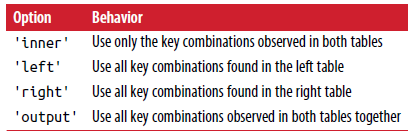
</p>

Many-to-many merges have well-defined, though not necessarily intuitive, behavior. Here’s an example:

In [42]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})

In [43]:
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                    'data2': range(5)})

In [44]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [45]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [46]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


**Many-to-many joins form the Cartesian product of the rows**

Since there were **three 'b' rows in the left DataFrame and two in the right one, there are six 'b' rows in the result**

The join method only affects the distinct key values appearing in the result:

In [47]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


To merge with multiple keys, pass a list of column names:

In [48]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})

In [49]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})

In [50]:
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [51]:
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [52]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


To determine which key combinations will appear in the result depending on the choice of merge method, think of the multiple keys as forming an array of tuples to be used as a single join key (even though it’s not actually implemented that way)

A last issue to consider in merge operations is the **treatment of overlapping column names**

While you can address the overlap manually, **merge has a suffixes option for specifying strings to append to overlapping names** in the left and right DataFrame objects:

In [53]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [54]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


See Table 8-2 for an argument reference on merge

Table 8-2. merge function arguments
<p align='center'>
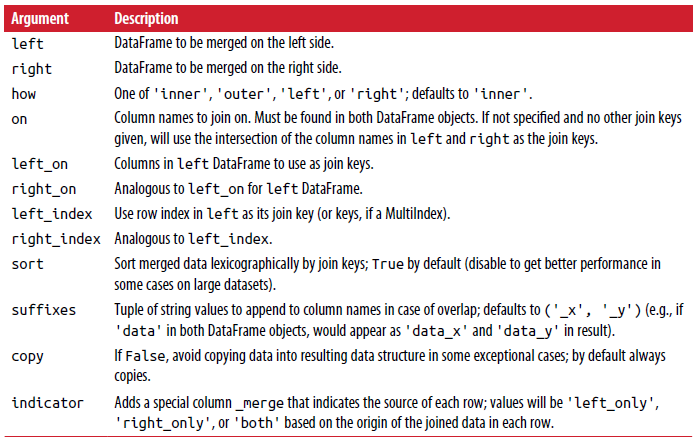
</p>

## Merging on Index

In some cases, **the merge key(s) in a DataFrame will be found in its index**

In this case, you can pass **left_index=True or right_index=True (or both) to indicate that the index should be used as the merge key:**

In [55]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})

In [56]:
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [57]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [58]:
right1

,group_val
a,3.5
b,7.0


In [59]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


Since the default merge method is to intersect the join keys, you can instead form the union of them with an outer join:

In [60]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


With **hierarchically** indexed data, things are more complicated, as **joining on index is implicitly a multiple-key merge:**

In [61]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                               'Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})

In [62]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio',
                              'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns=['event1', 'event2'])

In [63]:
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [64]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In this case, **you have to indicate multiple columns to merge on as a list** (note the handling of duplicate index values with how='outer'):

In [65]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [66]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
         right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


Using the indexes of both sides of the merge is also possible:

In [67]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])

In [68]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                      index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])

In [69]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [70]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [71]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame has a convenient **join** instance for **merging by index**

It can also be used to **combine together many DataFrame objects having the same or similar indexes but non-overlapping columns**

In the prior example, we could have written:

In [72]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In part for legacy reasons (i.e., much earlier versions of pandas), **DataFrame’s join method performs a left join on the join keys,** exactly preserving the left frame’s row index

It also **supports joining the index of the passed DataFrame on one of the columns of the calling DataFrame:**

In [73]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


Lastly, for simple index-on-index merges, you can **pass a list of DataFrames to join as an alternative to** using the more general **concat** function:

In [74]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                       index=['a', 'c', 'e', 'f'],
                       columns=['New York', 'Oregon'])

In [75]:
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [76]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [77]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


## Concatenating Along an Axis

Another kind of data combination operation is referred to interchangeably as **concatenation**, binding, or stacking

NumPy’s concatenate function can do this with NumPy arrays:

In [78]:
arr = np.arange(12).reshape((3, 4))

In [79]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [80]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In the context of pandas objects such as Series and DataFrame, having labeled axes enable you to further generalize array concatenation

In particular, you have a number of additional things to think about:
* If the **objects are indexed differently on the other axes, should we combine the distinct elements in these axes or use only the shared values** (the intersection)?

* Do the concatenated chunks of data need to be **identifiable in the resulting object?**

* **Does the “concatenation axis” contain data that needs to be preserved?** In many cases, the default integer labels in a DataFrame are best discarded during concatenation

The concat function in pandas provides a consistent way to address each of these concerns

I’ll give a number of examples to illustrate how it works. Suppose we have three Series with no index overlap:

In [81]:
s1 = pd.Series([0, 1], index=['a', 'b'])

In [82]:
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])

In [83]:
s3 = pd.Series([5, 6], index=['f', 'g'])

Calling concat with these objects in a list glues together the values and indexes:

In [84]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

By default concat works along axis =0, producing another Series

If you pass axis=1, the result will instead be a DataFrame (axis=1 is the columns):

In [85]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In this case there is no overlap on the other axis, which as you can see is the sorted union (the 'outer' join) of the indexes

You can instead intersect them by passing join='inner':

In [86]:
s4 = pd.concat([s1, s3])

In [87]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [88]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [89]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


In this last example, the 'f' and 'g' labels disappeared because of the join='inner' option

You can even specify the axes to be used on the other axes with join_axes:

In [90]:
#join_axes was deprecated in version 0.25
#pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])
#Use reindexing to achieve the same effect 
pd.concat([s1, s4], axis=1).reindex(['a', 'c', 'b', 'e'])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


A potential issue is that the **concatenated pieces are not identifiable in the result**

**Suppose instead you wanted to create a hierarchical index on the concatenation axis**

To do this, use the keys argument:

In [91]:
result = pd.concat([s1, s2, s3], keys=['one', 'two', 'three'])

In [92]:
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [93]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


In the case of combining Series along axis=1, the keys become the DataFrame column headers:

In [94]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


The same logic extends to DataFrame objects:

In [95]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
                   columns=['one', 'two'])

In [96]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
                   columns=['three', 'four'])

In [97]:
df1

,one,two
a,0,1
b,2,3
c,4,5


In [98]:
df2

,three,four
a,5,6
c,7,8


In [99]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

If you pass a dict of objects instead of a list, the dict’s keys will be used for the keys option:

In [100]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

We can name the created axis levels with the names argument:

In [101]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
          names=['upper', 'lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

A last consideration concerns DataFrames in which the **row index does not contain any relevant data:**

In [102]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])

In [103]:
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])

In [104]:
df1

,a,b,c,d
0,2.034789,-1.448906,1.346911,0.935704
1,0.494044,-0.153464,-1.108163,-1.634957
2,-0.904024,-0.241463,0.583000,0.798940


In [105]:
df2

,b,d,a
0,0.195291,-0.855822,-0.099292
1,0.824919,-0.074164,0.212250


In this case, you can pass ignore_index=True:

In [106]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,2.034789,-1.448906,1.346911,0.935704
1,0.494044,-0.153464,-1.108163,-1.634957
2,-0.904024,-0.241463,0.583000,0.798940
3,-0.099292,0.195291,NaN,-0.855822
4,0.212250,0.824919,NaN,-0.074164


There are additional arguments governing how the hierarchical index is created (see Table 8-3)

Table 8-3. concat function arguments
<p align='center'>
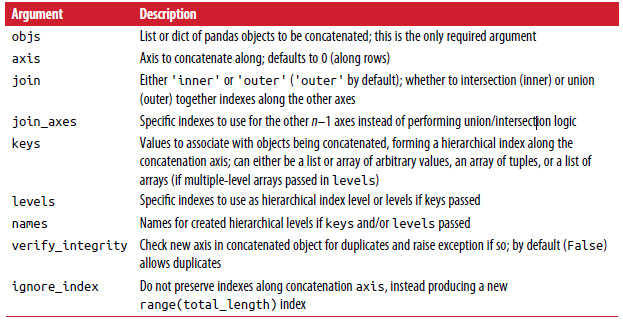
</p>

## Combining Data with Overlap

There is another data combination situation that can’t be expressed as either a merge or concatenation operation. **You may have two datasets whose indexes overlap in full or part**

As a motivating example, consider NumPy’ where function, which performs the array-oriented equivalent of an if-else expression:


In [107]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
              index=['f', 'e', 'd', 'c', 'b', 'a'])

In [108]:
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])

In [109]:
b[-1] = np.nan

In [110]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [111]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [112]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series has a **combine_first method, which performs the equivalent of this operation along with pandas’s usual data alignment logic:**

> Combine two DataFrame objects by **filling null values in one DataFrame with non-null values from other DataFrame.** The row and column indexes of the resulting DataFrame will be the **union of the two**

In [113]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

With DataFrames, combine_first does the same thing column by column, so you can think of it as “patching” missing data in the calling object with data from the object you pass:

In [114]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})

In [115]:
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7],
                    'b': [np.nan, 3., 4., 6., 8.]})

In [116]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [117]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [118]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


# 8.3 Reshaping and Pivoting

## Reshaping with Hierarchical Indexing

Hierarchical indexing provides a consistent way to rearrange data in a DataFrame. There are two primary actions:

stack
* This “rotates” or pivots from the columns in the data to the rows

unstack
* This pivots from the rows into the columns

Consider a small DataFrame with string arrays as row and column indexes:

In [119]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                    index=pd.Index(['Ohio', 'Colorado'], name='state'),
                    columns=pd.Index(['one', 'two', 'three'],
                    name='number'))

In [120]:
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


Using the stack method on this data **pivots the columns into the rows,** producing a Series:

In [121]:
result = data.stack()

In [122]:
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

From a hierarchically indexed Series, you can rearrange the data back into a Data-Frame with unstack:

In [123]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


By default the innermost level is unstacked (same with stack). You can unstack a different level by passing a level number or name:

In [124]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [125]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


**Unstacking might introduce missing data if all of the values in the level aren’t found in each of the subgroups:**

In [126]:
s1 = pd.Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])

In [127]:
s2 = pd.Series([4, 5, 6], index=['c', 'd', 'e'])

In [128]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])

In [129]:
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [130]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


Stacking filters out missing data by default, so the operation is more easily invertible:

In [131]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [132]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

When you **unstack in a DataFrame, the level unstacked becomes the lowest level in the result:**

In [133]:
df = pd.DataFrame({'left': result, 'right': result + 5},
                  columns=pd.Index(['left', 'right'], name='side'))

In [134]:
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [135]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [136]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

## Pivoting “Long” to “Wide” Format

A common way to store **multiple time series in databases and CSV** is in so-called **long or stacked format**

Let’s load some example data and do a small amount of time series wrangling and other data cleaning:


In [137]:
!mkdir examples
import urllib.request 
url = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/macrodata.csv'
filename = 'examples/macrodata.csv'
urllib.request.urlretrieve(url, filename)

mkdir: cannot create directory ‘examples’: File exists


('examples/macrodata.csv', <http.client.HTTPMessage at 0x7ff7e31586d0>)

In [138]:
data = pd.read_csv('examples/macrodata.csv')

In [139]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [140]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter,
                         name='date')

In [141]:
periods

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203, freq='Q-DEC')

In [142]:
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')

In [144]:
data = data.reindex(columns=columns)

In [147]:
data.index = periods.to_timestamp('D', 'end')

In [150]:
ldata = data.stack().reset_index().rename(columns={0: 'value'})

PeriodIndex combines the year and quarter columns to create a kind of time interval type

Now, ldata looks like:

In [151]:
ldata[:10]

,date,item,value
0,1959-03-31 23:59:59.999999999,realgdp,2710.349
1,1959-03-31 23:59:59.999999999,infl,0.000
2,1959-03-31 23:59:59.999999999,unemp,5.800
3,1959-06-30 23:59:59.999999999,realgdp,2778.801
4,1959-06-30 23:59:59.999999999,infl,2.340
5,1959-06-30 23:59:59.999999999,unemp,5.100
6,1959-09-30 23:59:59.999999999,realgdp,2775.488
7,1959-09-30 23:59:59.999999999,infl,2.740
8,1959-09-30 23:59:59.999999999,unemp,5.300
9,1959-12-31 23:59:59.999999999,realgdp,2785.204


This is the so-called **long format for multiple time series**, or other observational data with two or more keys (here, our keys are date and item). **Each row in the table repre sents a single observation**

**Data is frequently stored this way in relational databases like MySQL, as a fixed schema** (column names and data types) allows the number of distinct values in the item column to change as data is added to the table

In the previous example, **date and item would usually be the primary keys** (in relational database parlance), offering both relational integrity and easier joins

In some cases, the data may be more difficult to work with in this format; **you might prefer to have a DataFrame containing one column per distinct item value indexed by timestamps in the date column**

DataFrame’s pivot method performs exactly this transformation:

In [153]:
pivoted = ldata.pivot('date', 'item', 'value')

In [154]:
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31 23:59:59.999999999,0.00,2710.349,5.8
1959-06-30 23:59:59.999999999,2.34,2778.801,5.1
1959-09-30 23:59:59.999999999,2.74,2775.488,5.3
1959-12-31 23:59:59.999999999,0.27,2785.204,5.6
1960-03-31 23:59:59.999999999,2.31,2847.699,5.2
...,...,...,...
2008-09-30 23:59:59.999999999,-3.16,13324.600,6.0
2008-12-31 23:59:59.999999999,-8.79,13141.920,6.9
2009-03-31 23:59:59.999999999,0.94,12925.410,8.1


The **first two values** passed are the **columns to be used respectively as the row and column index,** **then finally an optional value column to fill the DataFrame**

Suppose you had two value columns that you wanted to reshape simultaneously:

In [155]:
ldata['value2'] = np.random.randn(len(ldata))

In [156]:
ldata[:10]

,date,item,value,value2
0,1959-03-31 23:59:59.999999999,realgdp,2710.349,1.330079
1,1959-03-31 23:59:59.999999999,infl,0.000,-1.760207
2,1959-03-31 23:59:59.999999999,unemp,5.800,0.403104
3,1959-06-30 23:59:59.999999999,realgdp,2778.801,0.833739
4,1959-06-30 23:59:59.999999999,infl,2.340,-1.532362
5,1959-06-30 23:59:59.999999999,unemp,5.100,0.492842
6,1959-09-30 23:59:59.999999999,realgdp,2775.488,1.269393
7,1959-09-30 23:59:59.999999999,infl,2.740,0.224915
8,1959-09-30 23:59:59.999999999,unemp,5.300,-1.035101
9,1959-12-31 23:59:59.999999999,realgdp,2785.204,-0.043500


By omitting the last argument, you obtain a DataFrame with hierarchical columns:

In [157]:
pivoted = ldata.pivot('date', 'item')

In [158]:
pivoted[:5]

value            ...    value2          
item                           infl   realgdp  ...   realgdp     unemp
date                                           ...                    
1959-03-31 23:59:59.999999999  0.00  2710.349  ...  1.330079  0.403104
1959-06-30 23:59:59.999999999  2.34  2778.801  ...  0.833739  0.492842
1959-09-30 23:59:59.999999999  2.74  2775.488  ...  1.269393 -1.035101
1959-12-31 23:59:59.999999999  0.27  2785.204  ... -0.043500  0.486521
1960-03-31 23:59:59.999999999  2.31  2847.699  ...  1.864448  1.163235

[5 rows x 6 columns]

In [159]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31 23:59:59.999999999,0.00,2710.349,5.8
1959-06-30 23:59:59.999999999,2.34,2778.801,5.1
1959-09-30 23:59:59.999999999,2.74,2775.488,5.3
1959-12-31 23:59:59.999999999,0.27,2785.204,5.6
1960-03-31 23:59:59.999999999,2.31,2847.699,5.2


Note that **pivot is equivalent to creating a hierarchical index using set_index followed by a call to unstack:**

In [163]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')

In [164]:
unstacked[:7]

value            ...    value2          
item                           infl   realgdp  ...   realgdp     unemp
date                                           ...                    
1959-03-31 23:59:59.999999999  0.00  2710.349  ...  1.330079  0.403104
1959-06-30 23:59:59.999999999  2.34  2778.801  ...  0.833739  0.492842
1959-09-30 23:59:59.999999999  2.74  2775.488  ...  1.269393 -1.035101
1959-12-31 23:59:59.999999999  0.27  2785.204  ... -0.043500  0.486521
1960-03-31 23:59:59.999999999  2.31  2847.699  ...  1.864448  1.163235
1960-06-30 23:59:59.999999999  0.14  2834.390  ...  0.813457 -0.300349
1960-09-30 23:59:59.999999999  2.70  2839.022  ...  1.168521  0.612532

[7 rows x 6 columns]

## Pivoting “Wide” to “Long” Format

**An inverse operation to pivot for DataFrames is pandas.melt**

Rather than transforming one column into many in a new DataFrame, **it merges multiple columns into one,** producing a DataFrame that is longer than the input

Let’s look at an example:

In [165]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'],
                   'A': [1, 2, 3],
                   'B': [4, 5, 6],
                   'C': [7, 8, 9]})

In [166]:
df

,key,A,B,C
0,foo,1,4,7
1,bar,2,5,8
2,baz,3,6,9


The 'key' column may be a group indicator, and the other columns are data values

**When using pandas.melt, we must indicate which columns (if any) are group indicators**

Let’s use 'key' as the only group indicator here:

In [167]:
melted = pd.melt(df, ['key'])

In [168]:
melted

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6
6,foo,C,7
7,bar,C,8
8,baz,C,9


Using pivot, we can reshape back to the original layout:

In [171]:
reshaped = melted.pivot('key', 'variable', 'value')

In [172]:
reshaped

variable,A,B,C
key,,,
bar,2,5,8
baz,3,6,9
foo,1,4,7


Since the result of pivot creates an index from the column used as the row labels, **we may want to use reset_index to move the data back into a column:**

In [176]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2,5,8
1,baz,3,6,9
2,foo,1,4,7


You can also specify a subset of columns to use as value columns:

In [177]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


pandas.melt can be used without any group identifiers, too:

In [178]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9


In [179]:
pd.melt(df, value_vars=['key', 'A', 'B'])

,variable,value
0,key,foo
1,key,bar
2,key,baz
3,A,1
4,A,2
5,A,3
6,B,4
7,B,5
8,B,6
